In [1]:
# Copyright (c) Sony AI Inc. All rights reserved.

# A View From Somewhere: Human-Centric Face Representations 

A View From Somewhere models project face images into a continuous, low-dimensional embedding space aligned with human perception. The embedding spaces, not only enable the accurate prediction of face similariy, but also provide a human-interpretable decomposition of the dimensions used in the human decision-making process. Conditional variants additionally provide the importance distinct annotators place on each dimension, permitting the projection of face images into a specific annotator's subspace, which encodes the annotator's notion of similarity.

### Imports

In [2]:
import sys
sys.path.append("..")

from glob import glob

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from avfs.build_avfs import load_registered_model
from avfs.dataset.loader import ImageDataset
from avfs.utils.align import align_faces
from avfs.utils.notebook import predict_random_triplet, dimension_top10_bottom10, AnnotatorInfo

### Prepare Data

While A View From Somewhere models were trained using real face images from the FFHQ dataset, in this example notebook we use synthetic face images generated by [StyleGAN3](https://github.com/NVlabs/stylegan3). If you use these images in your research, please give appropriate credit by using the following BibTeX entry:

```
@inproceedings{Karras2021,
author = {Tero Karras and Miika Aittala and Samuli Laine and Erik H\"ark\"onen and Janne Hellsten and Jaakko Lehtinen and Timo Aila},
title = {Alias-Free Generative Adversarial Networks},
booktitle = {Proc. NeurIPS},
year={2021}
}
```

First, align the sythetic face images and create a dataloader. 

In [3]:
image_paths = glob("../data/stylegan3/*.png")

In [4]:
align_faces(
    image_paths=image_paths, 
    image_size=160, 
    max_workers=99
)

In [5]:
dataset = ImageDataset(
    image_paths=image_paths, 
    fivecrop_trans=False
)

In [6]:
loader = DataLoader(
    dataset=dataset, 
    shuffle=False, 
    drop_last=False, 
    batch_size=256, 
    num_workers= 8, 
    pin_memory=True
)

### Load Model

Registered A View From Somewhere model names are as follows: 
- "avfs_cph"
- "avfs_c"
- "avfs_u"
- "avfs_u_half"
- "avfs_u_quarter"
- "avfs_u_eighth"

Refer to the [ICLR 2023 paper](https://arxiv.org/pdf/2303.17176.pdf) for more details on these models.

In [7]:
model_name = "avfs_cph"

model, annotator_labels = load_registered_model(
    devices=[],                       
    data_parallel=False,                                         
    primary_device="cpu",                                         
    model_name=model_name,                                           
    eval_mode=True
)

### Project Data

Project the synthetic face images into the continuous, low-dimensional embedding space.

In [8]:
embeddings = []

with torch.no_grad():
    for i, data in enumerate(loader):
        batch_embeddings = F.relu(model(data).detach().cpu())
        embeddings.append(batch_embeddings)
        
embeddings = torch.cat(embeddings).numpy()

### Make Predictions

Create a random triplet from the data and make an odd-out-out (i.e., least similar face) prediction, which is highlighted using a <span style="color:red">red</span> border.

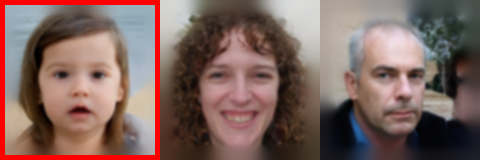

In [9]:
predict_random_triplet(image_paths, embeddings)

### Sort by Dimension

As the embedding space provides a human-interpretable decomposition of the dimensions used in the human decision-making process, it is interesting to sort the data based on their values in a specified dimension.

top 10/347 @ dimension 4


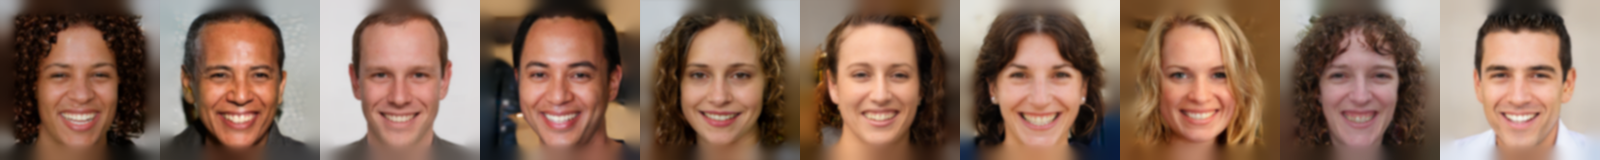

bottom 10/347 @ dimension 4


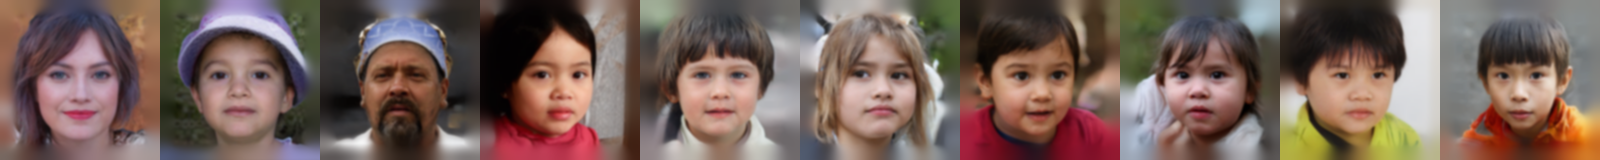

In [10]:
dimension_top10_bottom10(
    image_paths=image_paths, 
    embeddings=embeddings, 
    dim=4
)

### Project Data to Annotator Subspace

For conditional model variants, it is possible to further project the embeddings into annotator-specific subspaces. 

Create a random triplet from the data and make odd-out-out (i.e., least similar face) predictions based on five different annotator subspaces. Odd-one-out predictions are highlighted using a <span style="color:red">red</span> border. Further, above the triplet, the annotator's demographic information is shown.

Annotator ID: 0b896d3a-5d43-4aa1-a3d9-2ca7a6061df2
Age: 38, Gender Identity: female, Nationality: Indian, Ancestry Region(s): AS


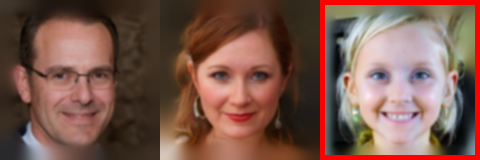

Annotator ID: cc810435-357d-4fe5-ab1d-edc7b6f5ea72
Age: 38, Gender Identity: female, Nationality: Ukrainian, Ancestry Region(s): EU


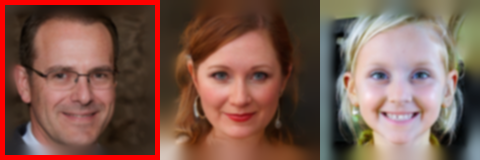

Annotator ID: 505ab1a7-5df7-4616-b982-8691e3b476eb
Age: 60, Gender Identity: female, Nationality: American, Ancestry Region(s): EU


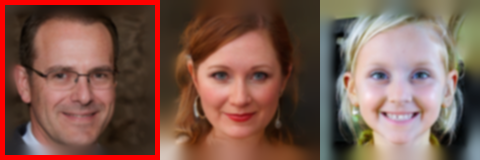

Annotator ID: 0ad17c51-9087-4f28-a3e3-b56a384471fe
Age: 30, Gender Identity: male, Nationality: American, Ancestry Region(s): EU


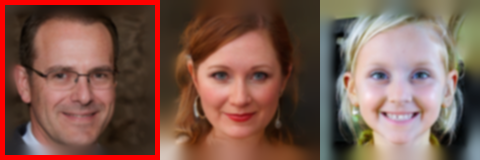

Annotator ID: 8319a658-7273-4938-8e6d-3fc6cdf95d74
Age: 39, Gender Identity: male, Nationality: American, Ancestry Region(s): EU


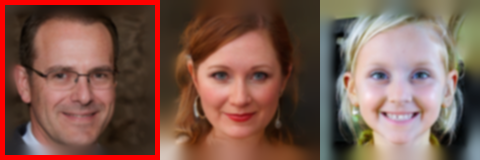

In [11]:
if model_name in ["avfs_cph", "avfs_c"]:
    annotator_info = AnnotatorInfo()
    
    try:
        masks = torch.sigmoid(model.masks.weight).detach().cpu().numpy()
    except AttributeError:
        masks = torch.sigmoid(model.module.masks.weight).detach().cpu().numpy()
        
    reversed_annotator_labels = {v: k for k, v in annotator_labels.items()}
    
    for mask_num in range(5,10):
        mask_annotator_info = annotator_info.annotator_identity(
            annotator_id=reversed_annotator_labels[mask_num]
        )
        
        print(f"Annotator ID: {reversed_annotator_labels[mask_num]}\n"
              f"Age: {mask_annotator_info['age']}"
              f", Gender Identity: {mask_annotator_info['gender_id']}"
              f", Nationality: {mask_annotator_info['nationality']}"
              f", Ancestry Region(s): {mask_annotator_info['ancestry_regions']}")

        predict_random_triplet(image_paths, embeddings, masks[mask_num], seed=6)
else:
    print("Unconditional model variants do not have annotator-specific masks (subspaces).")